This is a tutorial on how to use the ktools coupling to CLIMADA. The according term paper of Robert Blass provides further information and can be found here:
https://doi.org/10.3929/ethz-b-000480061

# Example 1

The first example we translate exposures, hazard, impact function and centroids to ktools. The example consists of a step function as an impact function. The discretization approach of the tranlation from CLIMADA to ktools can approximate a step function perfectly. Therefore, we expect the result in CLIMADA and ktools to be the same. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame

from climada import util
util.config.setup_logging('ERROR')

from climada.entity.entity_def import Entity
from climada.engine.impact import Impact
from climada.hazard.base import Hazard
from climada.hazard import Centroids
from scipy import sparse
from climada.entity import Exposures, ImpactFunc, ImpactFuncSet, IFTropCyclone

2021-04-12 22:42:49,862 - climada - DEBUG - Loading default config file: C:\Users\blass\OneDrive - ETHZ\ETH\9. Semester\climada_python\climada\conf\defaults.conf
2021-04-12 22:42:53,649 - climada - DEBUG - Loading user config file: C:\Users\blass\OneDrive - ETHZ\ETH\climada_python\climada.conf


C:\Users\blass\anaconda3\envs\climada_env\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Generate exposures
exp = DataFrame()
exp['value'] = np.array([1000, 1000, 1000, 1000])
exp['latitude'] = np.array([0, 0, 0, 0])
exp['longitude'] = np.array([1, 1, 1, 1])
exp['if_TC'] = np.ones(len(exp['value']), int)
exp = Exposures(exp)
exp.set_geometry_points()
exp.check()

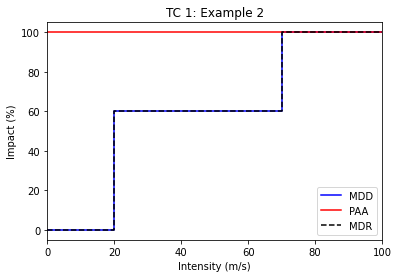

In [3]:
# Generate impact function
imp_fun = ImpactFunc()
imp_fun.haz_type = 'TC'
imp_fun.id = 1
imp_fun.name = 'Example 2'
imp_fun.intensity_unit = 'm/s'
imp_fun.intensity = np.array([0, 20, 20, 70, 70, 100])
imp_fun.mdd = np.array([0.0, 0.0, 0.6, 0.6, 1., 1.])
imp_fun.paa = np.array([1., 1., 1., 1., 1., 1.])
imp_fun.check()
imp_fun.plot()

imp_fun_set = ImpactFuncSet()
imp_fun_set.append(imp_fun)

In [4]:
# Generate hazard
hazard = Hazard('TC')
hazard.centroids = Centroids()
hazard.centroids.set_lat_lon(exp.latitude, exp.longitude, exp.crs)
hazard.centroids.region_id = np.array([1, 2, 3, 4])
hazard.centroids.check()
hazard.units = 'm/s'
hazard.event_id = np.array([1])
hazard.event_name = ['A']
hazard.frequency = np.array([1])
# Events x centroids
hazard.intensity = sparse.csr_matrix([[10, 80, 30, 60]])
hazard.fraction = sparse.csr_matrix([[1, 1, 1, 1]]) #other fraction than one cannot be translated to ktools
hazard.frequency = np.array([1.]) #other frequency than one cannot be translated to ktools
hazard.check()

In [5]:
# Assign centroids to exposures
exp.assign_centroids(hazard) 

haz_id = 1
haz_type = 'TC'
exp.rename(columns={"if_": "if_" + haz_type}, inplace=True)
exp['if_' + haz_type] = haz_id
exp.check()

In [6]:
# Compute the impact over the whole exposures
imp = Impact()
imp.calc(exp, imp_fun_set, hazard)

In [7]:
# Compute the impact with ktools
impk = Impact()
impk.calc_ktools(exp, imp_fun_set, hazard)

C:/msys32/mingw64/bin/evetobin < events.csv > events.bin
C:/msys32/mingw64/bin/damagebintobin < damage_bin_dict.csv > damage_bin_dict.bin
C:/msys32/mingw64/bin/coveragetobin < coverages.csv > coverages.bin
C:/msys32/mingw64/bin/itemtobin < items.csv > items.bin
C:/msys32/mingw64/bin/footprinttobin -i800 < footprint.csv
C:/msys32/mingw64/bin/vulnerabilitytobin -d800 < vulnerability.csv > vulnerability.bin
C:/msys32/mingw64/bin/gulsummaryxreftobin < gulsummaryxref.csv > gulsummaryxref.bin
C:/msys32/mingw64/bin/eve 1 1 
C:/msys32/mingw64/bin/getmodel
C:/msys32/mingw64/bin/gulcalc -S1 -c -
C:/msys32/mingw64/bin/summarycalc -g -1 - 
C:/msys32/mingw64/bin/eltcalc > eltcalc.csv


In [8]:
fmt = '{:<20}{:<20}{:<20}'
print(fmt.format('at_event climada', 'ktools', 'difference'))
for i in range(len(imp.at_event)):
    d = imp.at_event[i] - impk.at_event[i]
    print( fmt.format("%10.5e"% imp.at_event[i], "%10.5e"% impk.at_event[i],
                      "%10.5e"% d))   

print()
print(fmt.format('eai_exp climada', 'ktools', 'difference'))
for i in range(len(exp.centr_TC)):
    d = imp.eai_exp[i] - impk.eai_exp[i]
    print( fmt.format("%10.5e"% imp.eai_exp[i], "%10.5e"% impk.eai_exp[i],
                      "%10.5e"% d))
print()
fmt = '{:<20}{:<20}{:<20}'
print(fmt.format('measure', 'sum climada', 'sum ktools'))
print(fmt.format('at_event', sum(imp.at_event), sum(impk.at_event))) 
print(fmt.format('eai_exp', sum(imp.eai_exp), sum(impk.eai_exp)))

at_event climada    ktools              difference          
2.20000e+03         2.20000e+03         0.00000e+00         

eai_exp climada     ktools              difference          
0.00000e+00         0.00000e+00         0.00000e+00         
1.00000e+03         1.00000e+03         0.00000e+00         
6.00000e+02         6.00000e+02         0.00000e+00         
6.00000e+02         6.00000e+02         0.00000e+00         

measure             sum climada         sum ktools          
at_event            2200.0              2200.0              
eai_exp             2200.0              2200.0              


As expected, the results match. 

# Second example

In the second example we analyse a piecewise linear impact function with varying MDD and PAA slopes. We can specify a different hazard frequency than one, but this is not translated to ktools. It is also not included in the computation of uncertainty in ktools.

In [9]:
# Generate exposure 
exp = DataFrame()
exp['value'] = np.array([1000, 1000, 1000, 1000])
exp['latitude'] = np.array([0, 0, 0, 0])
exp['longitude'] = np.array([1, 1, 1, 1])
exp['if_TC'] = np.ones(len(exp['value']), int)
exp = Exposures(exp)
exp.set_geometry_points()
exp.check()

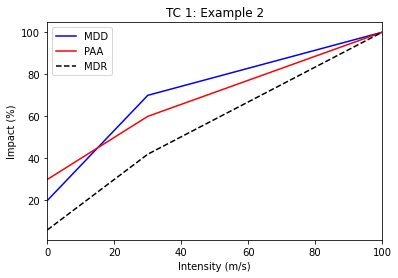

In [10]:
# Generate impact function
imp_fun = ImpactFunc()
imp_fun.haz_type = 'TC'
imp_fun.id = 1
imp_fun.name = 'Example 2'
imp_fun.intensity_unit = 'm/s'
imp_fun.intensity = np.array([0, 30, 100])
imp_fun.mdd = np.array([0.2, 0.7, 1.0])
imp_fun.paa = np.array([0.3, 0.6, 1.0])
imp_fun.check()
imp_fun.plot()

imp_fun_set = ImpactFuncSet()
imp_fun_set.append(imp_fun)

In [11]:
# Generate hazard
hazard = Hazard('TC')
hazard.centroids = Centroids()
hazard.centroids.set_lat_lon(exp.latitude, exp.longitude, exp.crs)
hazard.centroids.region_id = np.array([1, 2, 3, 4])
hazard.centroids.check()
hazard.units = 'm/s'
hazard.event_id = np.array([1])
hazard.event_name = ['A']
hazard.frequency = np.array([1])
# events x centroids
hazard.intensity = sparse.csr_matrix([[10, 80, 30, 45]])
hazard.fraction = sparse.csr_matrix([[1, 1, 1, 1]])
hazard.frequency = np.array([0.4])
hazard.check()

In [12]:
# Assign centroids to exposures
exp.assign_centroids(hazard) 

haz_id = 1
haz_type = 'TC'
exp.rename(columns={"if_": "if_" + haz_type}, inplace=True)
exp['if_' + haz_type] = haz_id
exp.check()

In [13]:
# Compute the impact over the whole exposures
imp = Impact()
imp.calc(exp, imp_fun_set, hazard)

In [14]:
# Compute the impact with ktools
impk = Impact()
impk.calc_ktools(exp, imp_fun_set, hazard)

C:/msys32/mingw64/bin/evetobin < events.csv > events.bin
C:/msys32/mingw64/bin/damagebintobin < damage_bin_dict.csv > damage_bin_dict.bin
C:/msys32/mingw64/bin/coveragetobin < coverages.csv > coverages.bin
C:/msys32/mingw64/bin/itemtobin < items.csv > items.bin
C:/msys32/mingw64/bin/footprinttobin -i800 < footprint.csv
C:/msys32/mingw64/bin/vulnerabilitytobin -d800 < vulnerability.csv > vulnerability.bin
C:/msys32/mingw64/bin/gulsummaryxreftobin < gulsummaryxref.csv > gulsummaryxref.bin
C:/msys32/mingw64/bin/eve 1 1 
C:/msys32/mingw64/bin/getmodel
C:/msys32/mingw64/bin/gulcalc -S1 -c -
C:/msys32/mingw64/bin/summarycalc -g -1 - 
C:/msys32/mingw64/bin/eltcalc > eltcalc.csv


In [15]:
fmt = '{:<20}{:<20}{:<20}'
print(fmt.format('at_event climada', 'ktools', 'difference'))
for i in range(len(imp.at_event)):
    d = imp.at_event[i] - impk.at_event[i]
    print( fmt.format("%10.5e"% imp.at_event[i], "%10.5e"% impk.at_event[i],
                      "%10.5e"% d))   

print()
print(fmt.format('eai_exp climada', 'ktools', 'difference'))
for i in range(len(exp.centr_TC)):
    d = imp.eai_exp[i] - impk.eai_exp[i]
    print( fmt.format("%10.5e"% imp.eai_exp[i], "%10.5e"% impk.eai_exp[i],
                      "%10.5e"% d))
print()
fmt = '{:<20}{:<20}{:<20}'
print(fmt.format('measure', 'sum climada', 'sum ktools'))
print(fmt.format('at_event', sum(imp.at_event), sum(impk.at_event))) 
print(fmt.format('eai_exp', sum(imp.eai_exp), sum(impk.eai_exp)))

at_event climada    ktools              difference          
1.90054e+03         1.89987e+03         6.75138e-01         

eai_exp climada     ktools              difference          
5.86667e+01         5.85014e+01         1.65226e-01         
3.23918e+02         3.24027e+02         -1.08391e-01        
1.68000e+02         1.67801e+02         1.98608e-01         
2.09633e+02         2.09618e+02         1.46111e-02         

measure             sum climada         sum ktools          
at_event            1900.5442176870747  1899.86908          
eai_exp             760.21768707483     759.9476320000001   


Since we discretize the impact function in ktools, we do not get the exactly same values as in CLIMADA. 
By using a lot of fine bins the error can be kept small.

# Demo Example

In this example we get a closer look at the effect of the discretization.

In [16]:
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5

In [17]:
exp = Exposures()
exp.read_hdf5(EXP_DEMO_H5)
#exp.plot_hexbin()

In [18]:
haz= Hazard()
haz.read_hdf5(HAZ_DEMO_H5)
#haz.plot_intensity(0)

In [19]:
impf = IFTropCyclone()
impf.set_emanuel_usa()

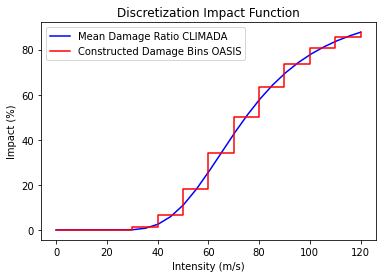

In [20]:
#hand example to show the discretization of the impact function
xx = np.arange(0, 120, 0.001)
mdr = impf.calc_mdr(xx)*100
plt.plot(xx, mdr, label = 'Mean Damage Ratio CLIMADA', color = 'b')
discrete_intensity_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

#compute damage bins
discrete_mdr_range = impf.calc_mdr(discrete_intensity_range)
damage_bin_from = discrete_mdr_range
damage_bin_to = np.append(discrete_mdr_range[1:], impf.calc_mdr(max(discrete_intensity_range)))
damage_bin_interpolation = 0.5 * (damage_bin_from + damage_bin_to)
y = damage_bin_interpolation * 100

plt.step(discrete_intensity_range, y, where = 'post', label = 'Constructed Damage Bins OASIS', color = 'r')
plt.legend(loc=2, prop={'size': 10})
plt.title('Discretization Impact Function')
plt.xlabel('Intensity (m/s)')
plt.ylabel('Impact (%)')
plt.show()

The intensities for which the impact function is defined, are put into multiple bins. Then for every such bin the impact percentage is computed, which then corresponds to the damage bin (its middle value).

In [21]:
impf_set = ImpactFuncSet()
impf_set.append(impf)

In [22]:
imp = Impact()
imp.calc(exp, impf_set, haz)

In [23]:
impk = Impact()
impk.calc_ktools(exp, impf_set, haz)

C:/msys32/mingw64/bin/evetobin < events.csv > events.bin
C:/msys32/mingw64/bin/damagebintobin < damage_bin_dict.csv > damage_bin_dict.bin
C:/msys32/mingw64/bin/coveragetobin < coverages.csv > coverages.bin
C:/msys32/mingw64/bin/itemtobin < items.csv > items.bin
C:/msys32/mingw64/bin/footprinttobin -i606 < footprint.csv
C:/msys32/mingw64/bin/vulnerabilitytobin -d606 < vulnerability.csv > vulnerability.bin
C:/msys32/mingw64/bin/gulsummaryxreftobin < gulsummaryxref.csv > gulsummaryxref.bin
C:/msys32/mingw64/bin/eve 1 1 
C:/msys32/mingw64/bin/getmodel
C:/msys32/mingw64/bin/gulcalc -S1 -c -
C:/msys32/mingw64/bin/summarycalc -g -1 - 
C:/msys32/mingw64/bin/eltcalc > eltcalc.csv


In [24]:
fmt = '{:<20}{:<20}{:<20}'
print(fmt.format('at_event climada', 'ktools', 'difference'))
for i in range(len(imp.at_event)):
    d = imp.at_event[i] - impk.at_event[i]
    print( fmt.format("%10.5e"% imp.at_event[i], "%10.5e"% impk.at_event[i],
                      "%10.5e"% d))   

print()
print(fmt.format('eai_exp climada', 'ktools', 'difference'))
for i in range(len(exp.centr_TC)):
    d = imp.eai_exp[i] - impk.eai_exp[i]
    print( fmt.format("%10.5e"% imp.eai_exp[i], "%10.5e"% impk.eai_exp[i],
                      "%10.5e"% d))
print()
fmt = '{:<20}{:<20}{:<20}'
print(fmt.format('measure', 'sum climada', 'sum ktools'))
print(fmt.format('at_event', sum(imp.at_event), sum(impk.at_event))) 
print(fmt.format('eai_exp', sum(imp.eai_exp), sum(impk.eai_exp)))

at_event climada    ktools              difference          
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00000e+00         0.00000e+00         
0.00000e+00         0.00

C:/msys32/mingw64/bin/evetobin < events.csv > events.bin
C:/msys32/mingw64/bin/damagebintobin < damage_bin_dict.csv > damage_bin_dict.bin
C:/msys32/mingw64/bin/coveragetobin < coverages.csv > coverages.bin
C:/msys32/mingw64/bin/itemtobin < items.csv > items.bin
C:/msys32/mingw64/bin/footprinttobin -i3 < footprint.csv
C:/msys32/mingw64/bin/vulnerabilitytobin -d3 < vulnerability.csv > vulnerability.bin
C:/msys32/mingw64/bin/gulsummaryxreftobin < gulsummaryxref.csv > gulsummaryxref.bin
C:/msys32/mingw64/bin/eve 1 1 
C:/msys32/mingw64/bin/getmodel
C:/msys32/mingw64/bin/gulcalc -S1 -c -
C:/msys32/mingw64/bin/summarycalc -g -1 - 
C:/msys32/mingw64/bin/eltcalc > eltcalc.csv
C:/msys32/mingw64/bin/evetobin < events.csv > events.bin
C:/msys32/mingw64/bin/damagebintobin < damage_bin_dict.csv > damage_bin_dict.bin
C:/msys32/mingw64/bin/coveragetobin < coverages.csv > coverages.bin
C:/msys32/mingw64/bin/itemtobin < items.csv > items.bin
C:/msys32/mingw64/bin/footprinttobin -i6 < footprint.csv
C:/ms

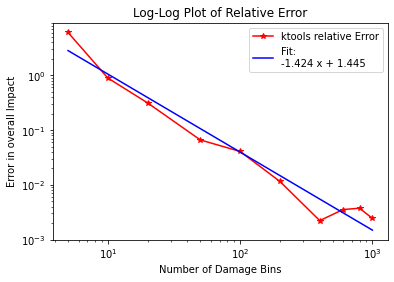

In [25]:
imp = Impact()
imp.calc(exp, impf_set, haz)
n_damage_bins = [5, 10, 20, 50, 100, 200, 400, 600, 800, 1000]
at_event = []
for i in n_damage_bins:
    impk = Impact()
    impk.calc_ktools(exp, impf_set, haz, i)
    diff = np.zeros(len(impk.at_event))
    for j in range(len(impk.at_event)):
        diff[j] = impk.at_event[j] - imp.at_event[j]
    at_event.append(sum(abs(diff)))

x = np.array(n_damage_bins)
y = np.array(at_event / sum(imp.at_event))

linear_model = np.polyfit(np.log10(x), np.log10(y), 1)
linear_model_fct = np.poly1d(linear_model)

plt.plot(x,y , 'r', label = 'ktools relative Error', marker = '*')
plt.plot(x, 10**linear_model_fct(np.log10(x)), 'b', label = 'Fit: %s' %linear_model_fct)

plt.legend(loc=1, prop={'size': 10})
plt.title('Log-Log Plot of Relative Error')
plt.xlabel('Number of Damage Bins')
plt.ylabel('Error in overall Impact')
plt.xscale('log')
plt.yscale('log')

This is a log-log plot of the number of damage bins to the relative error in overall impact (sum of all impacts). We can see that with increasing number of damage bins the relative error in overall impact decays exponentially. Thus, with many damage bins the results of ktools are a good approximation of the CLIMADA computation. This shows that the data translation from CLIMADA to ktools works.

# Uncertainty Example

This example introduces the uncertainty computation of ktools. The exposures, impact functions and hazard data are inserted in CLIMADA and than translated to ktools. This tool is usefull for simple examples but cumbersome for more complex ones because the probability values needed by ktools need to be inserted for every combination by hand.

In [26]:
from climada.engine.impact_ktools import ImpactKtools

In [27]:
exp = DataFrame()
exp['value'] = np.array([1000000, 1000000, 1000000, 1000000])
exp['latitude'] = np.array([50, 50, -50, -50])
exp['longitude'] = np.array([-50, 50, -50, 50])
exp['if_TC'] = np.ones(len(exp['value']), int)
exp = Exposures(exp)
exp.set_geometry_points()
exp.check()
#exp.plot_hexbin()

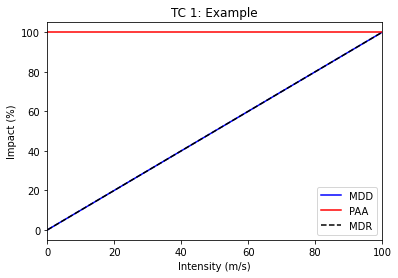

In [28]:
imp_fun = ImpactFunc()
imp_fun.haz_type = 'TC'
imp_fun.id = 1
imp_fun.name = 'Example'
imp_fun.intensity_unit = 'm/s'
imp_fun.intensity = np.array([0, 40, 100])
imp_fun.mdd = np.array([0.0, 0.4, 1.0])
imp_fun.paa = np.array([1., 1., 1.])
imp_fun.check()

imp_fun_set = ImpactFuncSet()
imp_fun_set.append(imp_fun)
imp_fun_set.plot()
plt.show()

In [29]:
hazard = Hazard('TC')
hazard.centroids = Centroids()
hazard.centroids.set_lat_lon(np.array([50, 50, -50]), np.array([-50, 50, -50]), exp.crs)
hazard.centroids.region_id = np.array([1, 2, 3])
hazard.centroids.check()
hazard.units = 'm/s'
hazard.event_id = np.array([1, 2, 3])
hazard.event_name = ['A', 'B', 'C']
# events x centroids
hazard.intensity = sparse.csr_matrix([[20, 0, 0], [90, 0, 0], [10, 0, 0]])
hazard.fraction = sparse.csr_matrix([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
hazard.frequency = np.array([1, 1, 1])
hazard.check()
# Assign centroids to exposures
exp.assign_centroids(hazard)  

haz_id = 1
haz_type = 'TC'
exp.rename(columns={"if_": "if_" + haz_type}, inplace=True)
exp['if_' + haz_type] = haz_id
exp.check()

In [30]:
imp = Impact()
imp.calc(exp, imp_fun_set, hazard)

In [31]:
# Define additional information needed for ktools uncertainty example.
# Example close to presentation example of OASIS
damage_bins = np.array([0.0, 0.4, 1.])
n_damage_bins = len(damage_bins) - 1
n_intensity_bins = 3 #ktools defines exact intensity bins itself
vulnerability_ids = np.array([1, 2]) #example with two vulnerability functions
vul_id_per_area = np.random.choice(vulnerability_ids, size=exp.centr_TC.size)

#probability of intensities in vulnerability file
l = n_damage_bins * n_intensity_bins * len(vulnerability_ids)
vulnerability_prob = np.full(l, 0.8)

#probability of damages in footprint file
k = hazard.intensity.count_nonzero() * n_intensity_bins
footprint_prob = np.array([0.7, 0.7, 0.7, 1, 1, 1, 0.7, 0.7, 0.7]) 
#footprint_prob = np.random.uniform(size = k)
sample_size = 100

def_bins = {
    'n_damage_bins': n_damage_bins,
    'damage_bins': damage_bins,
    'n_intensity_bins': n_intensity_bins,
    'vulnerability_ids': vulnerability_ids,
    'vul_id_per_area': vul_id_per_area,
    'footprint_prob': footprint_prob,
    'vulnerability_prob': vulnerability_prob,
    'sample_size': sample_size
}

In [32]:
impk = ImpactKtools()
impk.calc_ktools(exp, imp_fun_set, hazard, def_bins)

C:/msys32/mingw64/bin/evetobin < events.csv > events.bin
C:/msys32/mingw64/bin/damagebintobin < damage_bin_dict.csv > damage_bin_dict.bin
C:/msys32/mingw64/bin/coveragetobin < coverages.csv > coverages.bin
C:/msys32/mingw64/bin/itemtobin < items.csv > items.bin
C:/msys32/mingw64/bin/footprinttobin -i3 < footprint.csv
C:/msys32/mingw64/bin/vulnerabilitytobin -d2 < vulnerability.csv > vulnerability.bin
C:/msys32/mingw64/bin/occurrencetobin -P-1899.0 -D  < occurrence.csv > occurrence.bin
C:/msys32/mingw64/bin/gulsummaryxreftobin < gulsummaryxref.csv > gulsummaryxref.bin
C:/msys32/mingw64/bin/eve 1 1 
C:/msys32/mingw64/bin/getmodel
C:/msys32/mingw64/bin/gulcalc -S100 -c -
C:/msys32/mingw64/bin/summarycalc -g -1 - 
C:/msys32/mingw64/bin/eltcalc > eltcalc.csv


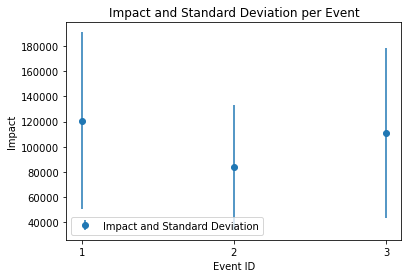

In [33]:
plt.errorbar(hazard.event_id, impk.at_event, yerr=impk.sd_at_event, fmt='o', label='Impact and Standard Deviation')
plt.legend(loc=3, prop={'size': 10})
plt.title('Impact and Standard Deviation per Event')
plt.xlabel('Event ID')
plt.ylabel('Impact')
x = [1,2,3]
values = ['1', '2', '3']
plt.xticks(x, values)
plt.show()